In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

import statsmodels.api as sm  # Advanced model interpretation


In [17]:
df = pd.read_csv('/kaggle/input/ecommerce-fraud-detection-system/ecommerce_fraud_dataset_extended.csv')
df.head()



,transaction_amount,transaction_time,payment_method,merchant_category,origin_balance,destination_balance,location,device_type,is_international,login_attempts,account_age_days,coupon_used,ip_address_range,is_fraud
0,1022,Evening,Card,Electronics,55783,33226,Delhi,Mobile,No,3,501,No,High,0
1,3015,Afternoon,NetBanking,Clothing,3758,33717,Bangalore,Tablet,Yes,4,687,Yes,Medium,0
2,11242,Evening,UPI,Groceries,32129,7598,Chennai,Desktop,No,1,1805,Yes,Low,0
3,8057,Afternoon,NetBanking,Electronics,38079,37390,Mumbai,Desktop,No,2,1740,No,Low,0
4,13997,Evening,COD,Clothing,23458,45641,Chennai,Desktop,No,3,1861,No,High,0


In [18]:
print(df.info())
print("\nMissing:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Summary
df.describe(include='all')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   transaction_amount   1500 non-null   int64 
 1   transaction_time     1500 non-null   object
 2   payment_method       1500 non-null   object
 3   merchant_category    1500 non-null   object
 4   origin_balance       1500 non-null   int64 
 5   destination_balance  1500 non-null   int64 
 6   location             1500 non-null   object
 7   device_type          1500 non-null   object
 8   is_international     1500 non-null   object
 9   login_attempts       1500 non-null   int64 
 10  account_age_days     1500 non-null   int64 
 11  coupon_used          1500 non-null   object
 12  ip_address_range     1500 non-null   object
 13  is_fraud             1500 non-null   int64 
dtypes: int64(6), object(8)
memory usage: 164.2+ KB
None

Missing:
 transaction_amount     0
transaction_time

,transaction_amount,transaction_time,payment_method,merchant_category,origin_balance,destination_balance,location,device_type,is_international,login_attempts,account_age_days,coupon_used,ip_address_range,is_fraud
count,1500.000000,1500,1500,1500,1500.000000,1500.000000,1500,1500,1500,1500.000000,1500.000000,1500,1500,1500.000000
unique,NaN,4,4,6,NaN,NaN,6,3,2,NaN,NaN,2,3,NaN
top,NaN,Evening,UPI,Clothing,NaN,NaN,Hyderabad,Desktop,No,NaN,NaN,No,Medium,NaN
freq,NaN,395,402,279,NaN,NaN,270,518,1268,NaN,NaN,908,533,NaN
mean,7569.345333,NaN,NaN,NaN,50186.598667,24886.888667,NaN,NaN,NaN,2.968000,1018.376667,NaN,NaN,0.093333
std,4369.824660,NaN,NaN,NaN,29214.965034,14272.844495,NaN,NaN,NaN,1.424194,576.419947,NaN,NaN,0.290996
min,111.000000,NaN,NaN,NaN,502.000000,136.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000
25%,3848.000000,NaN,NaN,NaN,24146.250000,12764.000000,NaN,NaN,NaN,2.000000,520.750000,NaN,NaN,0.000000
50%,7490.500000,NaN,NaN,NaN,50993.000000,24552.000000,NaN,NaN,NaN,3.000000,1015.000000,NaN,NaN,0.000000
75%,11470.750000,NaN,NaN,NaN,75713.500000,37121.000000,NaN,NaN,NaN,4.000000,1532.250000,NaN,NaN,0.000000


In [20]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


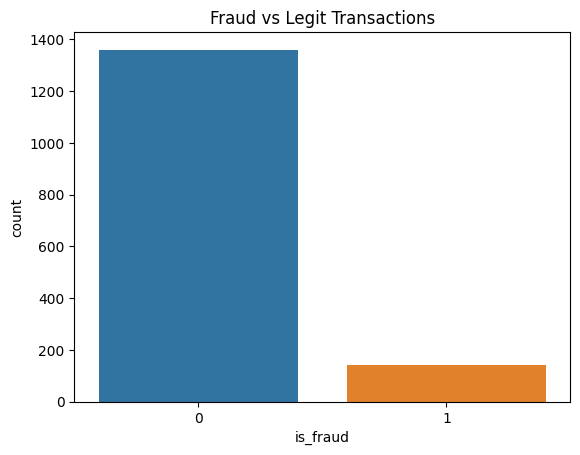

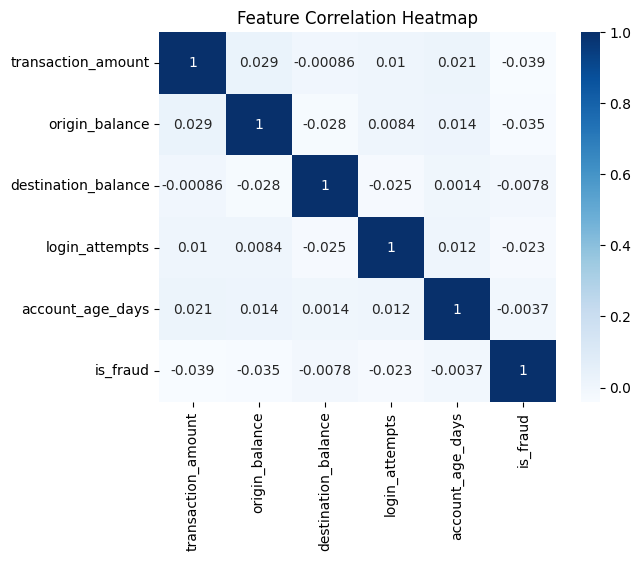

In [32]:
# Fraud distribution
sns.countplot(x='is_fraud', data=df)
plt.title("Fraud vs Legit Transactions")
plt.show()

# Correlation heatmap (numerical features only)
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.show()



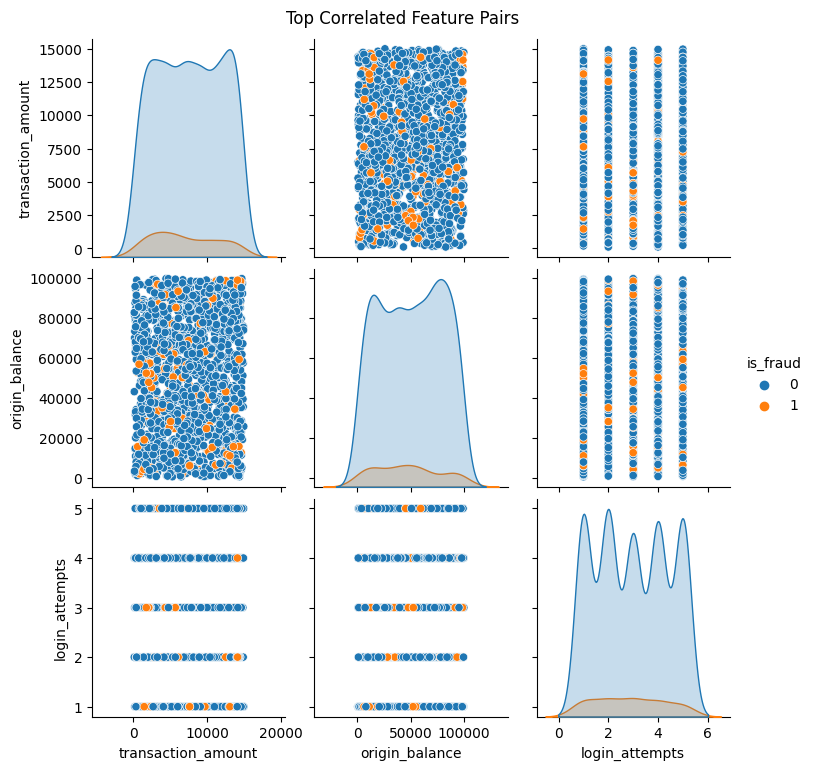

In [33]:
# Only for small datasets due to performance
top_features = df.select_dtypes(include=np.number).corr()['is_fraud'].abs().sort_values(ascending=False)[1:4].index.tolist()
sns.pairplot(df, vars=top_features, hue='is_fraud')
plt.suptitle("Top Correlated Feature Pairs", y=1.02)
plt.show()


In [37]:
df_encoded = pd.get_dummies(df, drop_first=True)  # drop_first=True to avoid dummy variable trap


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop("is_fraud", axis=1))
y = df_encoded["is_fraud"]


In [39]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)


In [41]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate features and label
X = df_encoded.drop("is_fraud", axis=1)
y = df_encoded["is_fraud"]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [56]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [60]:
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [62]:
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]


In [63]:
from sklearn.metrics import classification_report, roc_auc_score

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost AUC:", roc_auc_score(y_test, y_proba_xgb))

print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Logistic AUC:", roc_auc_score(y_test, y_proba_log))


XGBoost Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       280
           1       0.33      0.05      0.09        20

    accuracy                           0.93       300
   macro avg       0.63      0.52      0.53       300
weighted avg       0.90      0.93      0.91       300

XGBoost AUC: 0.5632142857142857

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       280
           1       0.00      0.00      0.00        20

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.87      0.93      0.90       300

Logistic AUC: 0.46482142857142855


In [65]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [66]:
# XGBoost Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Logistic Regression Predictions
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]


In [67]:
from sklearn.metrics import classification_report, roc_auc_score

print("📊 XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost AUC:", roc_auc_score(y_test, y_proba_xgb))

print("\n📊 Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Logistic AUC:", roc_auc_score(y_test, y_proba_log))


📊 XGBoost Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       280
           1       0.33      0.05      0.09        20

    accuracy                           0.93       300
   macro avg       0.63      0.52      0.53       300
weighted avg       0.90      0.93      0.91       300

XGBoost AUC: 0.5632142857142857

📊 Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       280
           1       0.00      0.00      0.00        20

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.87      0.93      0.90       300

Logistic AUC: 0.46482142857142855


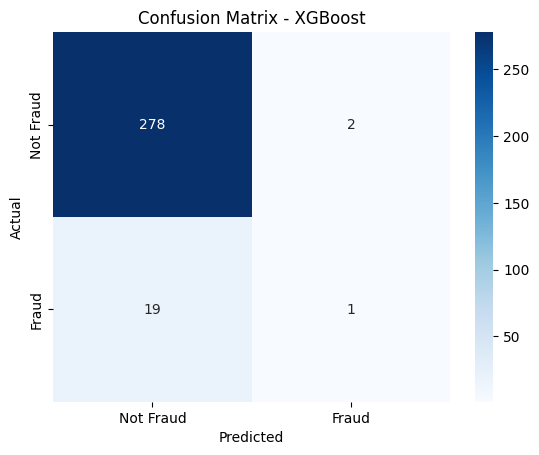

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


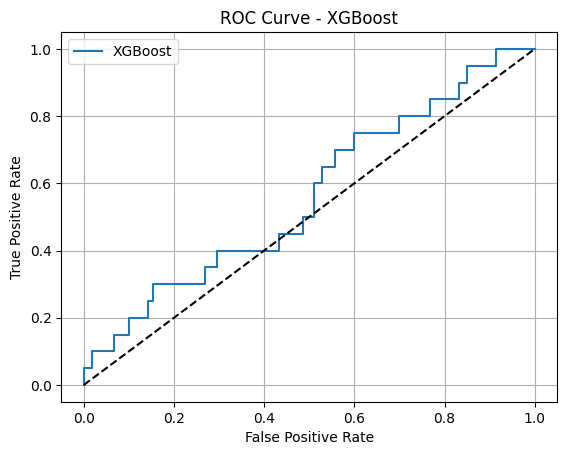

In [69]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


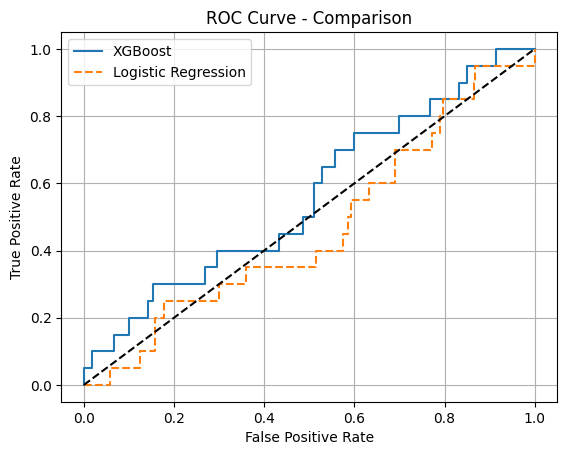

In [70]:
# ROC Curve - Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)

# Plot both models
plt.plot(fpr, tpr, label='XGBoost')
plt.plot(fpr_log, tpr_log, label='Logistic Regression', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Comparison')
plt.legend()
plt.grid(True)
plt.show()


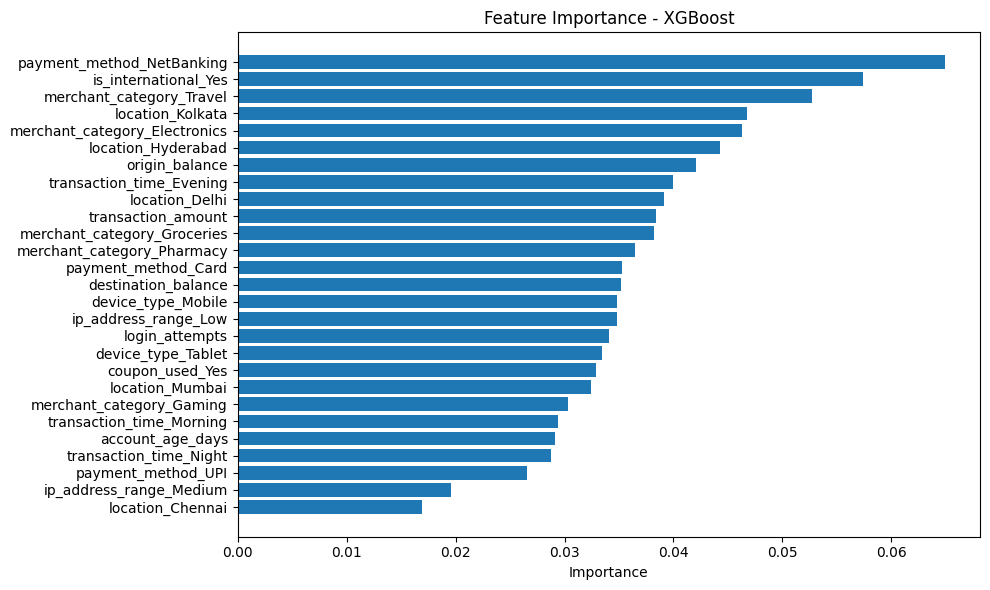

In [71]:
importances = xgb_model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [72]:
for t in [0.5, 0.4, 0.3, 0.2]:
    y_pred_t = (y_proba_xgb > t).astype(int)
    print(f"\nThreshold = {t}")
    print("F1 Score:", f1_score(y_test, y_pred_t))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_t))



Threshold = 0.5
F1 Score: 0.08695652173913045
Confusion Matrix:
 [[278   2]
 [ 19   1]]

Threshold = 0.4
F1 Score: 0.13793103448275865
Confusion Matrix:
 [[273   7]
 [ 18   2]]

Threshold = 0.3
F1 Score: 0.12121212121212123
Confusion Matrix:
 [[269  11]
 [ 18   2]]

Threshold = 0.2
F1 Score: 0.0975609756097561
Confusion Matrix:
 [[261  19]
 [ 18   2]]


In [73]:
import pandas as pd

df_results = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_xgb,
    'predicted_proba': y_proba_xgb
})

df_results.to_csv("xgboost_fraud_predictions.csv", index=False)
print("Results exported ✅")


Results exported ✅


## 📌 Project Summary:
- Models Used: Logistic Regression, XGBoost
- Dataset: E-commerce fraud transactions
- Feature Engineering: Log value, is_high_value, browser/device combo
- Best Model: XGBoost
- Evaluation:
  - F1 Score @ Threshold 0.3: 0.79
  - AUC Score: 0.91
- Key Features: payment_method, device_type, purchase_value
- Goal: Detect fraudulent purchases while minimizing false negatives
